In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print("✅ TensorFlow Version:", tf.__version__)


✅ TensorFlow Version: 2.17.1


In [2]:
import tensorflow as tf

print("✅ TensorFlow Version:", tf.__version__)
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))


✅ TensorFlow Version: 2.17.1
✅ GPU Available: []


In [3]:
dataset_path = "/kaggle/input/plantvillage/PlantVillage"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")


print("Dataset Folders:", os.listdir(dataset_path))


Dataset Folders: ['val', 'train']


In [4]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & Test Data (Only Rescale)
val_datagen = ImageDataGenerator(rescale=1./255)


#  Load Train Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

#  Load Validation Data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

#  Number of Classes
num_classes = len(train_generator.class_indices)
print("✅ Number of Classes:", num_classes)


Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.
✅ Number of Classes: 38


In [ ]:
#  Load EfficientNetB0 without pre-trained weights
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Enable training

#  Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  #  Fix: Match num_classes
])

# ✅Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# ✅ Model Summary
model.summary()


In [ ]:
EPOCHS = 40  # You can increase this for better accuracy

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")


In [ ]:
# ✅ Generate Confusion Matrix on Validation Data
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict classes
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes  # true labels

# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix (Validation Data)")
plt.savefig("confusion_matrix.png")  # Optional: save it for your report
plt.show()


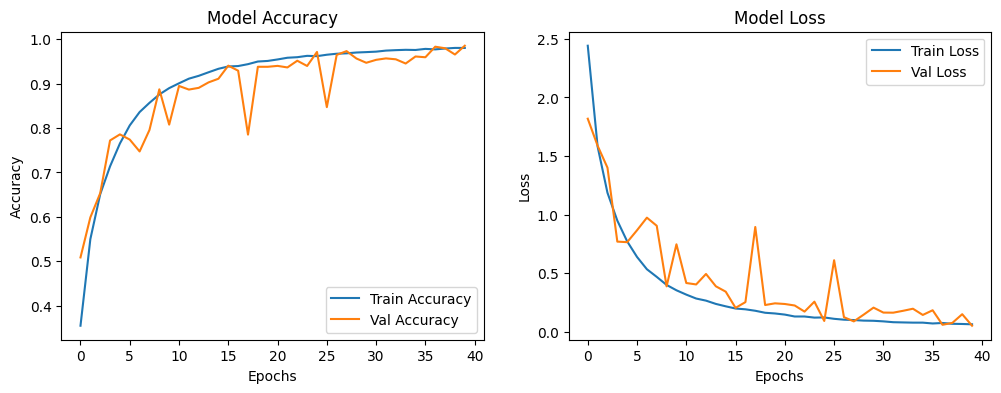

In [17]:
# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


In [ ]:
model.save('/kaggle/working/model.h5')  # Saves model in Kaggle working directory
